In [1]:
import wandb
import wandb.apis
import pandas as pd
from typing import *
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

api = wandb.Api()

In [2]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        assert run.summary["count"] == dict(squad=1000, cnn_dailymail=500)[task]
        assert run.config["model"] == "EleutherAI/pythia-1.4b"
        mc = run.summary["model_config"] if "model_config" in run.summary else {}
        d = run.config["sparsity"]
        if "importance" in d:
            d.update({f"importance_{k}": v for k, v in d.pop("importance").items()})
        return dict(
            task=task,
            **d,
            n_heads=mc.get("num_attention_heads", 16),
            head_size=mc.get("hidden_size", 2048)//mc.get("num_attention_heads", 16),
            prefill_length=run.summary["prefill_length"],
            match=run.summary.get("match"),
            rougeL=run.summary.get("rougeL"),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series) -> int:
    kv_elements = 0
    index_elements = 0
    if s["name"] == "dense":
        # write current + read all KVs
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"] * s["n_heads"]

    elif s["name"] in {"eviction", "ann_low_rank"}:
        # TODO: not counting eviction scores
        kv_elements = (2 + 2 * s["k"]) * s["head_size"] * s["n_heads"]
        if s["name"] == "ann_low_rank":
            index_elements = (2 + 2 * s["prefill_length"]) * s["rank"] * s["n_heads"]

    else:
        assert False, s["name"]

    return kv_elements + index_elements

df = (
    pd.concat([load_sweep("RMOE-53-low-rank-v4"), load_sweep("RMOE-55-sparse-compression")])
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    .pipe(lambda d: d.assign(score=d.match.where(~d.match.isna(), d.rougeL)))
    .pipe(lambda d: d[d.init!="normal"])
)
df.groupby("task").apply(lambda d: d.sort_values("score", ascending=False).head())

task    k         init          name  rank   
task                                                                    
cnn_dailymail 20  cnn_dailymail  256  orthonormal  ann_low_rank    64  \
              16  cnn_dailymail  512  orthonormal  ann_low_rank    64   
              17  cnn_dailymail  512  orthonormal  ann_low_rank    32   
              18  cnn_dailymail  512  orthonormal  ann_low_rank    16   
              28  cnn_dailymail   64  orthonormal  ann_low_rank    64   
squad         14          squad  256         None  ann_low_rank    64   
              48          squad  512  orthonormal  ann_low_rank    64   
              11          squad  256         None  ann_low_rank    32   
              8           squad  128         None  ann_low_rank    64   
              15          squad  128         None  ann_low_rank    32   

                  local_k  n_heads  head_size  prefill_length  match   
task                                                                   
cnn_dailymail 20       64       16        128        1204.210    NaN  \
              16      128       16        128        1204.210    NaN   
              17      128       16        128        1204.210    NaN   
              18      128       16        128        1204.210    NaN   
              28       16       16        128        1204.210    NaN   
squad         14       64       16        128        1410.755  0.424   
              48      128       16        128        1410.755  0.423   
              11       64       16        128        1410.755  0.423   
              8        32       16        128        1410.755  0.421   
              15       32       16        128        1410.755  0.418   

                    rougeL          method   transfers     score  
task                                                              
cnn_dailymail 20  0.184449             NaN  3520942.08  0.184449  
              16  0.181532             NaN  4569518.08  0.181532  
              17  0.180980             NaN  3335383.04  0.180980  
              18  0.179735             NaN  2718315.52  0.179735  
              28  0.179376             NaN  2734510.08  0.179376  
squad         14       NaN  max_components  3943946.24  0.424000  
              48       NaN             NaN  4992522.24  0.423000  
              11       NaN  max_components  2498309.12  0.423000  
              8        NaN  max_components  3419658.24  0.421000  
              15       NaN  max_components  1974021.12  0.418000

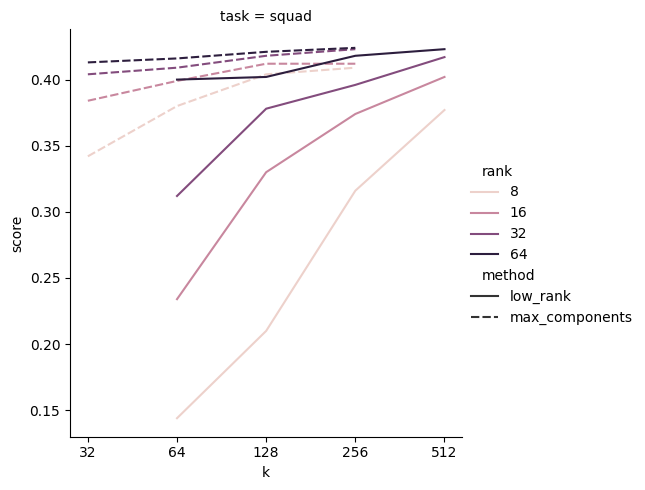

In [4]:
g = sns.relplot(data=df.pipe(lambda d: d.assign(rank=d["rank"].astype("long")))
                .pipe(lambda d: d[d.task == "squad"])
                .pipe(lambda d: d.assign(method=d.method.fillna("low_rank"))),
                y="score", x="k", hue="rank", style="method",
                col="task", hue_norm=matplotlib.colors.LogNorm(), kind="line", facet_kws=dict(sharey=False))
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())